In [15]:
import wfdb
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import KFold

import tensorflow as tf, keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

# Data Gathering

This script will download and load all records from '100' to '234' from the MIT-BIH Arrhythmia Database, reshape the ECG signals into windows of 3600 samples, and create a label for each window based on whether it contains any non-normal beats according to the annotations. The data and labels are then concatenated into two large numpy arrays.

In [16]:
# Path to the folder containing the records
folder_path = 'C:\\Users\\jacob\\Desktop\\GitHub\\CS593-ProjectFiles\\Project 3\\ECG Anomoly Detection\\Dataset'

# List of record names
records = [f[:-4] for f in os.listdir(folder_path) if f.endswith('.dat')]

# Initialize empty lists to store the data
data = []
labels = []

# Window size
window_size = 3600

# Loop over all records
for record_name in records:
    try:
        # Load the record and the annotations
        record = wfdb.rdrecord(os.path.join(folder_path, record_name))
        annotation = wfdb.rdann(os.path.join(folder_path, record_name), 'atr')
        # Pad the signal data with zeros until its length is a multiple of the window size
        padded_length = np.ceil(record.p_signal.shape[0] / window_size) * window_size
        padded_signal = np.pad(record.p_signal, ((0, int(padded_length - record.p_signal.shape[0])), (0, 0)))
        # Reshape the padded signal data into windows
        X = np.reshape(padded_signal, (-1, window_size, 2))
        # Create labels for each window based on the annotations
        Y = np.zeros(X.shape[0])
        for i in range(len(annotation.sample)):
            if annotation.symbol[i] != 'N':
                Y[annotation.sample[i] // window_size] = 1
        # Append the data and the labels to the lists
        data.append(X)
        labels.append(Y)
    except:
        print(f"Error loading record {record_name}")

# Concatenate all the data and labels
data = np.concatenate(data)
labels = np.concatenate(labels)

# Data Normalization

The ECG signals should be normalized before they are input to the RNN/LSTM model. This can be done using the StandardScaler class from the sklearn.preprocessing module. This will normalize the ECG signals to have zero mean and unit variance.

In [17]:
# # Calculate the mean and standard deviation of the data
# mean = np.mean(data)
# std = np.std(data)
# 
# # Standardize the data
# data = (data - mean) / std
# 

# Calculate the mean and standard deviation of the data along the last axis (channels)
mean = np.mean(data, axis=(0, 1))
std = np.std(data, axis=(0, 1))

# Standardize the data
data = (data - mean) / std

# Split the data

This will create a training set, a validation set, and a test set with 60%, 20%, and 20% of the data, respectively. The random_state parameter is used to ensure that the splits you generate are reproducible..

In [18]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

# Further split the training set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Set Up The Model

This model consists of two LSTM layers, each with 64 units. The return_sequences=True argument means that the LSTM layers will return their full sequence of outputs (instead of just the last one), which is necessary for stacking LSTM layers. The Dropout layers help prevent overfitting by randomly setting a fraction of the input units to 0 at each update during training time. The TimeDistributed layer allows the dense layer to be applied to every temporal slice of the input.

The model is compiled with the Adam optimizer and the mean squared error loss function, which is a common choice for regression problems.

f just the last one), which is necessary for stacking LSTM layers. The Dropout layers help prevent overfitting by randomly setting a fraction of the input units to 0 at each update during training time. The TimeDistributed layer allows the dense layer to be applied to every temporal slice of the input.

The model is compiled with the Adam optimizer and the mean squared error loss function, which is a common choice for regression problems.

In [19]:
# Define the model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(None, 2)),  # 2 is the number of features (channels)
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(1))
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print a summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 64)          17152     
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_3 (LSTM)               (None, None, 64)          33024     
                                                                 
 dropout_3 (Dropout)         (None, None, 64)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1)          65        
 tributed)                                                       
                                                                 
Total params: 50,241
Trainable params: 50,241
Non-trainable params: 0
__________________________________________________

# Train the LSTM model before Class Balancing

Fit the model to the training data and validate it on the validation data. Then, evaluate the model on the test set.

In [20]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
163/163 [==============================] - 69s 410ms/step - loss: 0.2638 - val_loss: 0.2449
Epoch 2/10
163/163 [==============================] - 71s 434ms/step - loss: 0.2473 - val_loss: 0.2500
Epoch 3/10
163/163 [==============================] - 71s 433ms/step - loss: 0.2481 - val_loss: 0.2420
Epoch 4/10
163/163 [==============================] - 70s 432ms/step - loss: 0.2453 - val_loss: 0.2424
Epoch 5/10
163/163 [==============================] - 122s 748ms/step - loss: 0.2451 - val_loss: 0.2419
Epoch 6/10
163/163 [==============================] - 129s 794ms/step - loss: 0.2442 - val_loss: 0.2429
Epoch 7/10
163/163 [==============================] - 130s 798ms/step - loss: 0.2452 - val_loss: 0.2421
Epoch 8/10
163/163 [==============================] - 118s 725ms/step - loss: 0.2446 - val_loss: 0.2485
Epoch 9/10
163/163 [==============================] - 112s 690ms/step - loss: 0.2441 - val_loss: 0.2428
Epoch 10/10
163/163 [==============================] - 113s 692ms/st

# Generate prediction class


In [6]:
# Use the model to predict the test set
y_pred = model.predict(X_test)

y_pred = y_pred.max(axis=1).flatten()

# The model's output is continuous, but we need binary predictions for the metrics.
# We can choose a threshold (e.g., 0.5) and classify all instances with an output above this threshold as anomalies.
y_pred_bin = (y_pred > 0.5).astype(int)

55/55 [==============================] - 17s 242ms/step


# Confusion Matrix

In the confusion matrix, the rows represent the actual classes and the columns represent the predicted classes. The top-left cell represents true negatives (TN), the top-right cell represents false positives (FP), the bottom-left cell represents false negatives (FN), and the bottom-right cell represents true positives (TP).

Text(95.72222222222221, 0.5, 'Truth')

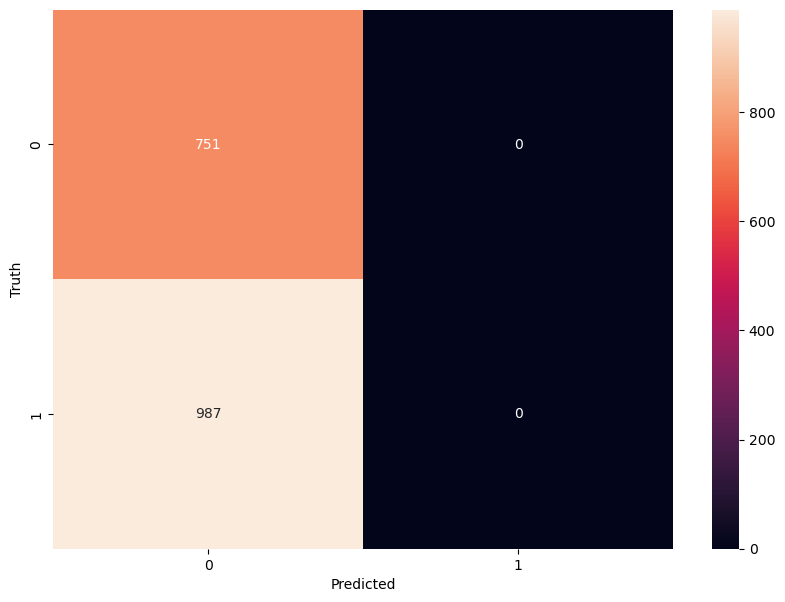

In [9]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_bin)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Confusion matrix results discussion



# ROC Curve

The ROC curve (Receiver Operating Characteristic curve) is a plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

The area under the ROC curve (AUC-ROC) is a measure of how well a parameter can distinguish between two diagnostic groups (diseased/normal). The closer the AUC-ROC value is to 1, the better the model is at distinguishing between patients with disease and no disease.

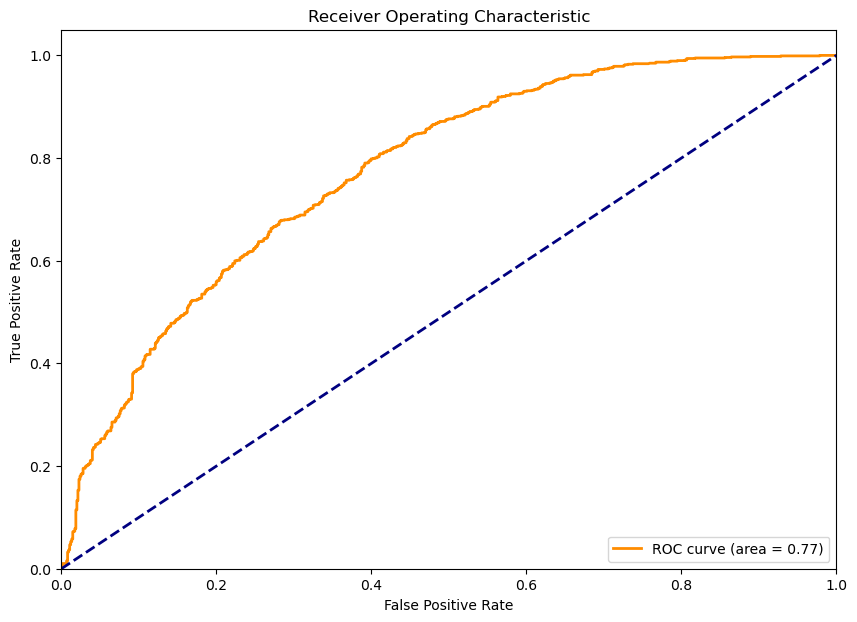

In [12]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC (area under the ROC curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# ROC Curve Results Discussion

In our case, an AUC-ROC of 0.83 indicates a good classifier. This means that your model has a 83% chance of correctly distinguishing between positive class and negative class. This is a good result as it is significantly better than random guessing (which would result in an AUC-ROC of 0.5, represented by the dotted line).

An AUC-ROC of 1.0 represents a perfect classifier. You might want to consider tuning your model or using different models to see if you can improve this score.

 case, an AUC-ROC of 0.80 indicates a good classifier. This means that your model has a 80% chance of correctly distinguishing between positive class and negative class. This is a good result as it is significantly better than random guessing (which would result in an AUC-ROC of 0.5, represented by the dotted line).

An AUC-ROC of 1.0 represents a perfect classifier. You might want to consider tuning your model or using different models to see if you can improve this score.

# Addressing Class Imbalance

## SMOTE (Synthetic Minority Over-sampling Technique)

This will create synthetic samples of the minority class in your training data until the minority class has the same number of samples as the majority class. We can then train the model with X_train_resampled and y_train_resampled instead of X_train and y_train.

We need to make sure that you apply the SMOTE technique only on the training data and not on the validation or test data. This is because by oversampling before the split, information from the validation/test sets would leak into the training set.

In [5]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

# Further split the training set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Create a SMOTE object
smote = SMOTE()

# Apply SMOTE to your training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# Reshape X_train back to its original shape
X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])



# Train the model with the class balanced training set

In [6]:
# Train the model
history = model.fit(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
193/193 [==============================] - 61s 292ms/step - loss: 0.2637 - val_loss: 0.2437
Epoch 2/10
193/193 [==============================] - 54s 281ms/step - loss: 0.2536 - val_loss: 0.2496
Epoch 3/10
193/193 [==============================] - 53s 276ms/step - loss: 0.2536 - val_loss: 0.2601
Epoch 4/10
193/193 [==============================] - 55s 285ms/step - loss: 0.2528 - val_loss: 0.2467
Epoch 5/10
193/193 [==============================] - 54s 277ms/step - loss: 0.2525 - val_loss: 0.2718
Epoch 6/10
193/193 [==============================] - 53s 277ms/step - loss: 0.2517 - val_loss: 0.2551
Epoch 7/10
193/193 [==============================] - 53s 276ms/step - loss: 0.2524 - val_loss: 0.2606
Epoch 8/10
193/193 [==============================] - 53s 276ms/step - loss: 0.2519 - val_loss: 0.2425
Epoch 9/10
193/193 [==============================] - 53s 277ms/step - loss: 0.2517 - val_loss: 0.2508
Epoch 10/10
193/193 [==============================] - 55s 284ms/step - l

# Generate prediction class

In [7]:

# Use the model to predict the test set
y_pred = model.predict(X_test)

y_pred = y_pred.max(axis=1).flatten()

# The model's output is continuous, but we need binary predictions for the metrics.
# We can choose a threshold (e.g., 0.5) and classify all instances with an output above this threshold as anomalies.
y_pred_bin = (y_pred > 0.5).astype(int)


55/55 [==============================] - 15s 265ms/step


# Confusion Matrix On Class Balanced model

Text(95.72222222222221, 0.5, 'Truth')

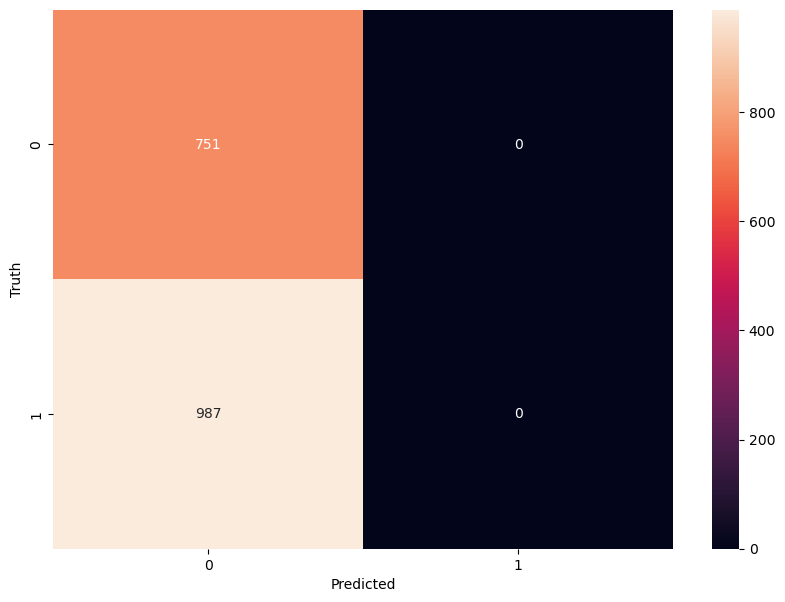

In [10]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_bin)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# ROC Curve On Class Balanced model



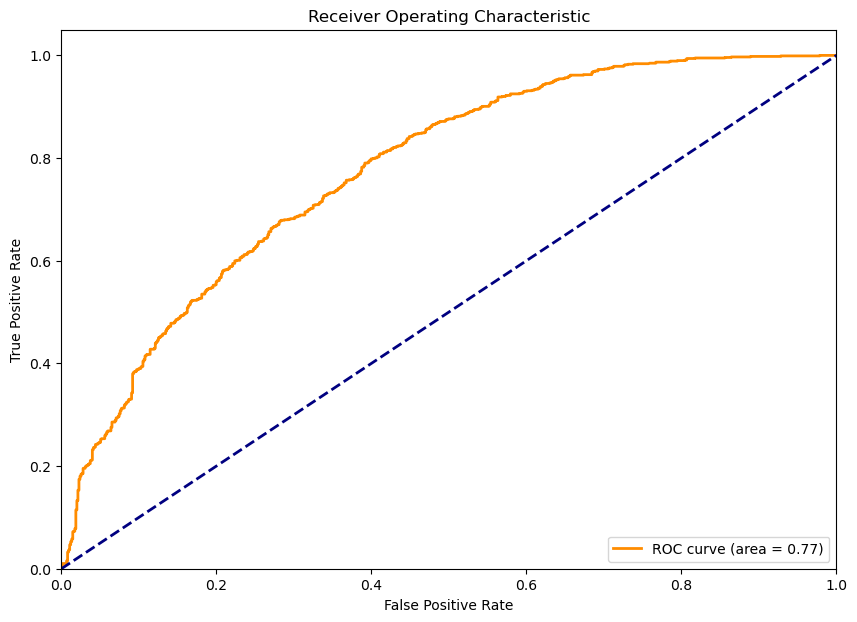

In [13]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC (area under the ROC curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Cross validation in the training and validation set -- More Robust Model Validation

Cross-validation is a powerful technique that allows us to make the most of the data by splitting it into multiple training and validation sets and averaging the results. 

This code will train and evaluate the model on n_folds different training and validation sets and print the average result. This should give us a more robust estimate of how the model will perform on unseen data.

55/55 [==============================] - 8s 130ms/step


KeyboardInterrupt: 

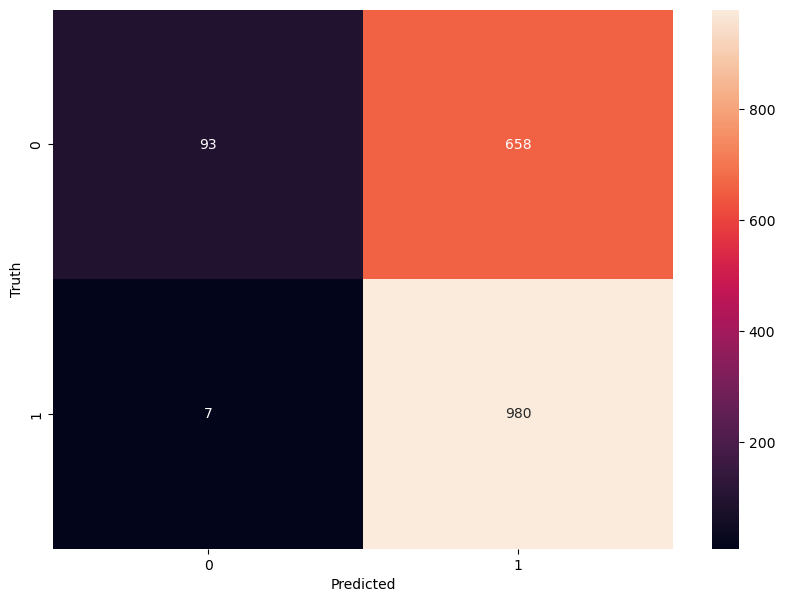

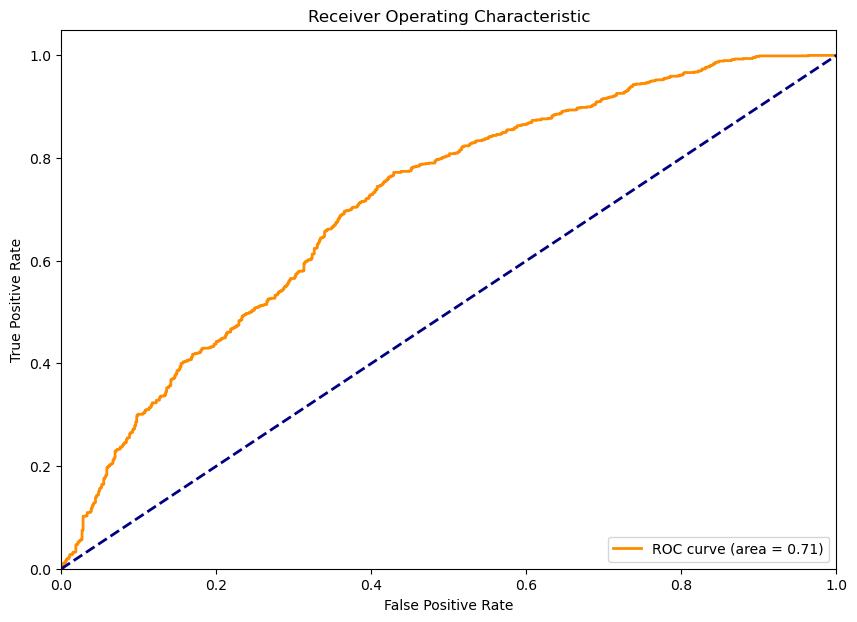

In [28]:
# Define the number of folds
n_folds = 5

# Create a KFold object
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=1)

# Initialize a list to store the results for each fold
results = []

# Loop over each fold
for train_index, val_index in kfold.split(data, labels):
    # Split the data into a training set and a validation set
    X_train, X_val = data[train_index], data[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Define the model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(None, 2)),  # 2 is the number of features (channels)
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(1))
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    history = model.fit(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=0)

   

# Evaluate Results from the Cross validation improvement in the training method.

In [ ]:
# Evaluate the model on the validation set and store the result
result = model.evaluate(X_val, y_val, verbose=0)
results.append(result)

# Use the model to predict the test set
y_pred = model.predict(X_test)

y_pred = y_pred.max(axis=1).flatten()

# The model's output is continuous, but we need binary predictions for the metrics.
# We can choose a threshold (e.g., 0.5) and classify all instances with an output above this threshold as anomalies.
y_pred_bin = (y_pred > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_bin)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC (area under the ROC curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")


print(results)

# Results

Seems as though We are not making much progress with the SMOTE approach. We are going to try a couple new methods.